
# Preprocessing para clustering (Issue 4)

Objetivo del notebook:
- Preparar dataset para modelado no supervisado.
- Definir variables de entrada para clustering.
- Escalar/codificar variables.
- Analizar estructura interna (PCA) y separabilidad preliminar.
- Evaluar evidencia inicial de clusters (codo + silhouette).
- Exportar dataset final transformado y dataset de perfilado.



## 1) Carga de datos y verificación inicial

Se parte del dataset limpio generado en EDA (`data/processed/handwriting_personality_clean.csv`).


In [1]:

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set_theme(style='whitegrid', context='notebook')
RANDOM_STATE = 42

project_root = Path('..').resolve() if Path.cwd().name == 'notebooks' else Path.cwd()
input_path = project_root / 'data' / 'processed' / 'handwriting_personality_clean.csv'

df = pd.read_csv(input_path)
print(f"Shape: {df.shape}")
df.head(3)


Shape: (2000, 23)


,Writing_Speed_wpm,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism,Gender,Age,Feature_1,Feature_2,...,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15
0,60,0.357203,0.407442,0.724947,0.451517,0.255107,Male,45,0.146139,0.289895,...,0.985927,0.745626,0.923922,0.039155,0.277361,0.832098,0.319128,0.199213,0.241081,0.375978
1,32,0.730250,0.051950,0.351615,0.528413,0.664159,Male,36,0.802833,0.548934,...,0.893979,0.114380,0.484167,0.022397,0.436322,0.908627,0.220744,0.650947,0.568464,0.660062
2,10,0.836987,0.162227,0.164681,0.816008,0.681870,Other,34,0.452513,0.441706,...,0.941274,0.950571,0.485661,0.277388,0.873560,0.566973,0.205402,0.537800,0.323519,0.373358


In [2]:

print('Valores únicos de Gender:')
print(df['Gender'].value_counts())


Valores únicos de Gender:
Gender
Other     693
Female    660
Male      647
Name: count, dtype: int64



## 2) Definición de variables para clustering y perfilado

Decisión metodológica:
- `X_cluster` incluye rasgos de escritura y demografía (`Writing_Speed_wpm`, `Age`, `Gender`, `Feature_1..Feature_15`).
- Los rasgos de personalidad Big Five se reservan como `Y_profile` para interpretación posterior de clusters.

Así evitamos que las variables objetivo de perfilado definan directamente la estructura de clustering.


In [3]:

big_five_cols = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']
base_cols = ['Writing_Speed_wpm', 'Age', 'Gender']
feature_cols = [c for c in df.columns if c.startswith('Feature_')]

x_cols = base_cols + feature_cols
y_profile_cols = big_five_cols

X = df[x_cols].copy()
Y_profile = df[y_profile_cols].copy()

print('X_cluster shape:', X.shape)
print('Y_profile shape:', Y_profile.shape)
print('Columnas X_cluster:', x_cols)


X_cluster shape: (2000, 18)
Y_profile shape: (2000, 5)
Columnas X_cluster: ['Writing_Speed_wpm', 'Age', 'Gender', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15']


## 3) Preprocesamiento (escalado + codificación categórica)

In [4]:

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print('Numéricas:', numeric_cols)
print('Categóricas:', categorical_cols)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ],
    remainder='drop'
)

X_transformed = preprocessor.fit_transform(X)

feature_names = preprocessor.get_feature_names_out()
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names, index=df.index)

print('Shape transformado:', X_transformed_df.shape)
X_transformed_df.head(3)


Numéricas: ['Writing_Speed_wpm', 'Age', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15']
Categóricas: ['Gender']
Shape transformado: (2000, 20)


,num__Writing_Speed_wpm,num__Age,num__Feature_1,num__Feature_2,num__Feature_3,num__Feature_4,num__Feature_5,num__Feature_6,num__Feature_7,num__Feature_8,num__Feature_9,num__Feature_10,num__Feature_11,num__Feature_12,num__Feature_13,num__Feature_14,num__Feature_15,cat__Gender_Female,cat__Gender_Male,cat__Gender_Other
0,1.699998,0.498818,-1.245883,-0.709052,-0.757852,0.384588,1.731094,1.685432,0.858962,1.496029,-1.592864,-0.793286,1.135773,-0.632607,-1.072436,-0.891973,-0.421163,0.0,1.0,0.0
1,-0.196414,-0.219653,1.040399,0.196265,-0.165196,0.995579,0.223452,1.367472,-1.320924,-0.063791,-1.651003,-0.240554,1.401398,-0.966704,0.489943,0.246159,0.557358,0.0,1.0,0.0
2,-1.686452,-0.379313,-0.179244,-0.178490,1.136932,0.330972,-0.064508,1.531019,1.566699,-0.058489,-0.766341,1.279789,0.215561,-1.018803,0.098608,-0.605381,-0.430187,0.0,0.0,1.0


## 4) Separabilidad estructural con PCA

In [5]:

pca = PCA(random_state=RANDOM_STATE)
X_pca_all = pca.fit_transform(X_transformed_df)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

pca_summary = pd.DataFrame({
    'component': np.arange(1, len(explained)+1),
    'explained_variance_ratio': explained,
    'cumulative_explained_variance': cum_explained
})

pca_summary.head(10)


,component,explained_variance_ratio,cumulative_explained_variance
0,1,0.066427,0.066427
1,2,0.063950,0.130377
2,3,0.063036,0.193414
3,4,0.061381,0.254795
4,5,0.059816,0.314611
5,6,0.058993,0.373604
6,7,0.058061,0.431665
7,8,0.057032,0.488697
8,9,0.056530,0.545227
9,10,0.056292,0.601519


In [6]:

thresholds = [0.8, 0.9, 0.95]
for t in thresholds:
    n_comp = int(np.argmax(cum_explained >= t) + 1)
    print(f'Componentes para >= {int(t*100)}% varianza: {n_comp}')


Componentes para >= 80% varianza: 14
Componentes para >= 90% varianza: 16
Componentes para >= 95% varianza: 17


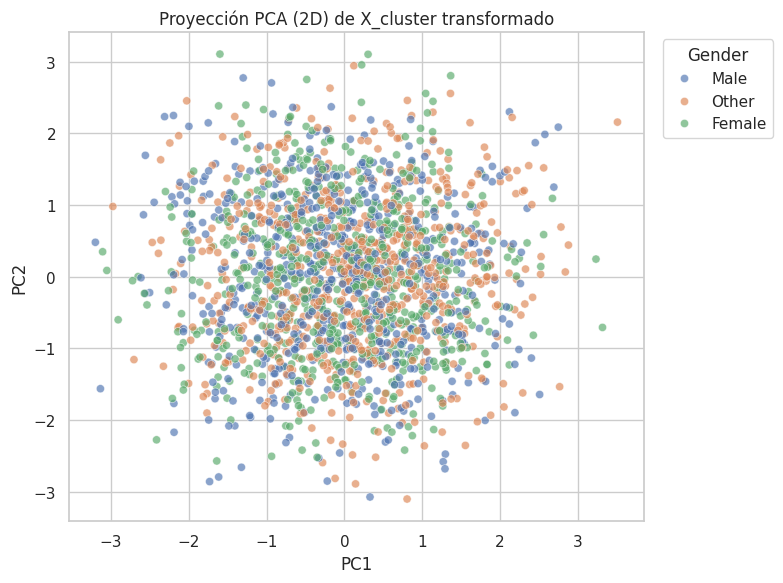

Varianza explicada PC1+PC2: 0.1304


In [7]:

pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d = pca_2d.fit_transform(X_transformed_df)

pca_plot_df = pd.DataFrame(X_pca_2d, columns=['PC1','PC2'], index=df.index)
pca_plot_df['Gender'] = df['Gender']

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_plot_df, x='PC1', y='PC2', hue='Gender', alpha=0.65, s=35)
plt.title('Proyección PCA (2D) de X_cluster transformado')
plt.legend(title='Gender', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

print('Varianza explicada PC1+PC2:', round(pca_2d.explained_variance_ratio_.sum(), 4))


## 5) Evaluación preliminar de posible existencia de clusters

In [8]:

k_values = list(range(2, 11))
inertias = []
silhouettes = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
    labels = km.fit_predict(X_transformed_df)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_transformed_df, labels))

metrics_df = pd.DataFrame({'k': k_values, 'inertia': inertias, 'silhouette': silhouettes})
metrics_df


,k,inertia,silhouette
0,2,33745.632105,0.044124
1,3,32719.391839,0.038172
2,4,31830.883912,0.039667
3,5,31196.005561,0.038702
4,6,30622.316266,0.038879
5,7,30134.434165,0.039026
6,8,29661.980998,0.039983
7,9,29250.112999,0.040330
8,10,28879.301657,0.042128


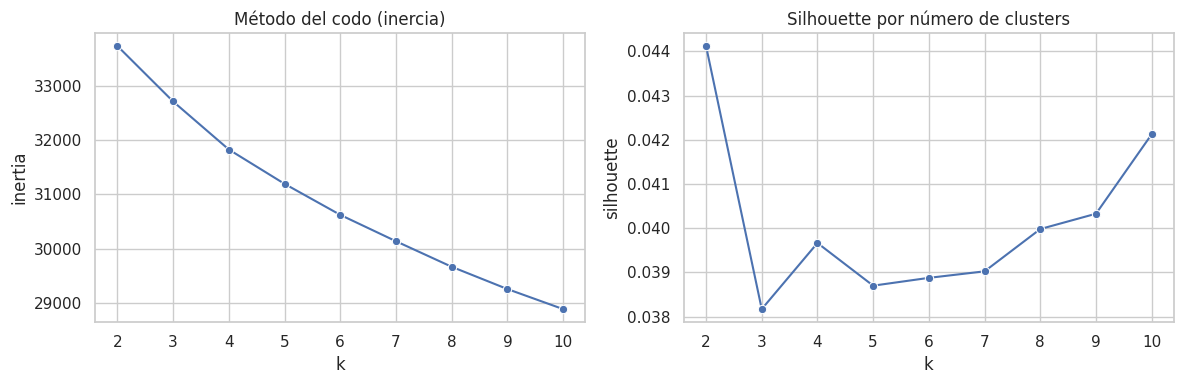

Mejor k preliminar por silhouette: 2 (score=0.0441)


In [9]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(data=metrics_df, x='k', y='inertia', marker='o', ax=axes[0])
axes[0].set_title('Método del codo (inercia)')

sns.lineplot(data=metrics_df, x='k', y='silhouette', marker='o', ax=axes[1])
axes[1].set_title('Silhouette por número de clusters')

plt.tight_layout()
plt.show()

best_k = metrics_df.loc[metrics_df['silhouette'].idxmax(), 'k']
best_s = metrics_df['silhouette'].max()
print(f'Mejor k preliminar por silhouette: {int(best_k)} (score={best_s:.4f})')


## 6) Exportación de datasets preparados

In [10]:

out_dir = project_root / 'data' / 'processed'
out_dir.mkdir(parents=True, exist_ok=True)

x_out = out_dir / 'handwriting_personality_clustering_input.csv'
y_out = out_dir / 'handwriting_personality_profile_targets.csv'
meta_out = out_dir / 'handwriting_personality_preprocessing_metadata.csv'

X_transformed_df.to_csv(x_out, index=False)
Y_profile.to_csv(y_out, index=False)

metadata = pd.DataFrame({
    'key': [
        'n_rows',
        'n_features_input_original',
        'n_features_after_transform',
        'categorical_encoding',
        'numeric_scaling',
        'best_k_by_silhouette'
    ],
    'value': [
        len(df),
        len(x_cols),
        X_transformed_df.shape[1],
        'onehot_multiclass (Gender with 3 categories)',
        'StandardScaler',
        int(best_k)
    ]
})
metadata.to_csv(meta_out, index=False)

print('Archivos exportados:')
print('-', x_out)
print('-', y_out)
print('-', meta_out)


Archivos exportados:
- /workspace/Proyecto-9-Aprendizaje-No-supervisado/data/processed/handwriting_personality_clustering_input.csv
- /workspace/Proyecto-9-Aprendizaje-No-supervisado/data/processed/handwriting_personality_profile_targets.csv
- /workspace/Proyecto-9-Aprendizaje-No-supervisado/data/processed/handwriting_personality_preprocessing_metadata.csv



## 7) Decisiones documentadas

1. Se separan variables de clusterización (`X_cluster`) y variables de perfilado (`Y_profile` = Big Five).
2. `Gender` se trata como variable categórica multiclase (Female/Male/Other), codificada con one-hot.
3. Variables numéricas de `X_cluster` se escalan con `StandardScaler`.
4. Se utiliza PCA para análisis estructural y visualización 2D de separabilidad.
5. Se aplica evaluación preliminar de estructura de clusters con inercia (codo) y silhouette.
6. Se exporta dataset transformado final para modelado y dataset de perfilado para interpretación posterior.
